# Graph Convolutional Network by Kipf and Welling

## Imports

In [8]:
import sys
sys.path.append('../code')

In [9]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import pickle
import copy
import numpy as np

import itertools

import performance as pf

In [10]:
import os
os.listdir("../data/permutations")

['cora_permutation1.pickle',
 'cora_permutation2.pickle',
 'cora_permutation3.pickle',
 'cora_permutation4.pickle']

## GNN Definition

In [11]:
from GCN import GCN_Net

## Data Loading

In [13]:
from dgl.data import citation_graph as citegrh
import networkx as nx

data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labels = th.LongTensor(data.labels)
mask = th.BoolTensor(data.train_mask)
g = data.graph

# add self loop
g.remove_edges_from(nx.selfloop_edges(g))
g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())

In [ ]:
citeseer_data = dgl.data.CitationGraphDataset("citeseer")
citeseer_features = th.FloatTensor(citeseer_data.features)
citeseer_labels = th.LongTensor(citeseer_data.labels)
citeseer_mask = th.BoolTensor(citeseer_data.train_mask)
citeseer_g = citeseer_data.graph

# add self loop
citeseer_g.remove_edges_from(nx.selfloop_edges(citeseer_g))
citeseer_g = DGLGraph(citeseer_g)
citeseer_g.add_edges(citeseer_g.nodes(), citeseer_g.nodes())

## Select Training, Validation and Test Set

In [16]:
percentage_train = 0.1
percentage_val = 0.1

with open("../data/permutations/cora_permutation1.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

#features=th.eye(g.number_of_nodes())

In [17]:
features.shape

torch.Size([2708, 2433])

## Training

In [18]:
loss_function = pf.perm_inv_loss(labels)

In [ ]:
import time

net = GCN_Net(g=g, in_feats=features.shape[1], hidden_size=150, hidden_layers=1, out_feats=len(np.unique(labels)),
              dropout=0.4, batchnorm=True)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(10000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = net(features)
    train_rand=pf.rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand=pf.rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>100:
        break
    
    net.train()

    # Compute loss for train nodes
    logits = net(features)

    #loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss = F.nll_loss(logits[mask_train], labels[mask_train])
    loss_ev.append(loss.detach().item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

In [21]:
net.load_state_dict(current_best_params)

<All keys matched successfully>

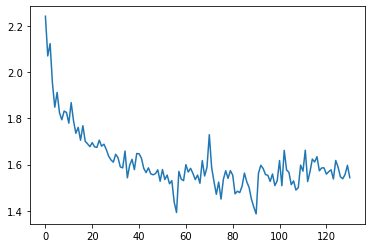

In [23]:
import seaborn as sns
sns.lineplot(x=range(len(loss_ev)), y=loss_ev)

## Evaluation

In [28]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
pf.performance_as_df(labels,final_prediction,{"train":mask_train,"val":mask_val,"test":mask_val})

,All,Train,Val,Test
Rand-Index,0.132544,0.166516,0.131345,0.131345
Mutual Information,0.153119,0.201808,0.159858,0.159858
Variation of Information,2.527880,2.326399,2.370255,2.370255
